# Local optima in a Siamese neural network
Repeated training shows that our Siamese neural network is prone to getting stuck in degenerate local optima, where they attempt to memorize our dataset, achieving only mediocre training accuracy, and abysmal validation accuracy.

Enable logging.

In [2]:
import logging


logging.basicConfig(level=logging.INFO)

Make sure that all annotated page and screen images can fit into the cache.

In [3]:
from video699.configuration import CONFIGURATION


CONFIGURATION['ImageABC']['lru_cache_maxsize'] = '2000'
CONFIGURATION['ScreenABC']['lru_cache_maxsize'] = '1000'

Conserve VRAM by instructing TensorFlow to allocate memory on demand.

In [4]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session


config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True
sess = tf.Session(config=config)
set_session(sess)

Using TensorFlow backend.


## Dataset

Find the minimum dimensions of a screen.

In [5]:
from video699.video.annotated import AnnotatedSampledVideoScreenDetector, get_videos


SCREEN_DETECTOR = AnnotatedSampledVideoScreenDetector(('pristine',))

max_width, max_height = float('-inf'), float('-inf')
for video in get_videos().values():
  for frame in video:
    for screen in SCREEN_DETECTOR.detect(frame):
      max_width = max(max_width, screen.width)
      max_height = max(max_height, screen.height)
max_width, max_height

(381, 286)

Construct a dataset of matching and non-matching image pairs.

In [6]:
from random import shuffle

import cv2 as cv
from keras.utils import Sequence
from math import ceil
import numpy as np
from video699.common import COLOR_RGBA_TRANSPARENT, rescale_and_keep_aspect_ratio
from video699.video.annotated import AnnotatedSampledVideoScreenDetector


BATCH_SIZE = 8
IMAGE_WIDTH = max_width
IMAGE_HEIGHT = max_height
MEAN_SCREEN_IMAGE = 0.0
MEAN_PAGE_IMAGE = 0.0
INVERSE_SCREEN_IMAGE_STDDEV = 1.0
INVERSE_PAGE_IMAGE_STDDEV = 1.0
LOGGER = logging.getLogger(__name__)
MATCHING_WEIGHT_RATIO = 0.5
RESCALE_INTERPOLATION = cv.INTER_LINEAR
SCREEN_DETECTOR = AnnotatedSampledVideoScreenDetector(('pristine',))


class AnnotatedImagePairs(Sequence):
  def __init__(self, videos, batch_size=BATCH_SIZE):
    samples = []
    
    for video in videos:
      documents = set(video.documents.values())
      for frame in video:
        for screen in SCREEN_DETECTOR.detect(frame):
          fully_matching_pages, incrementally_matching_pages, _ = screen.matching_pages()
          matching_pages = set(fully_matching_pages) | set(incrementally_matching_pages)
          matching_documents = set(page.document for page in matching_pages)
          nonmatching_weights = 1.0

          for document in matching_documents:
            for page in document:
              if page not in matching_pages:
                label = 1
                weight = 5.0
                samples.append((screen, page, label, weight))
                nonmatching_weights += weight

          for document in documents - matching_documents:
            for page in document:
              label = 1
              weight = 2.0
              samples.append((screen, page, label, weight))
              nonmatching_weights += weight
          
          matching_weights = nonmatching_weights * MATCHING_WEIGHT_RATIO / (1 - MATCHING_WEIGHT_RATIO)
          for page in fully_matching_pages:
            label = 0
            weight = matching_weights / len(matching_pages)
            samples.append((screen, page, label, weight))
      
    LOGGER.info('Produced a dataset containing {} annotated image pairs'.format(len(samples)))
    
    shuffle(samples)

    self.batch_size = batch_size
    self.samples = samples
    self.weight_norm = len(samples) / sum(weight for screen, page, label, weight in samples)
  
  @property
  def labels(self):
    samples = self.samples
    for screen, page, label, weight in samples:
      yield label

  def __len__(self):
    batch_size = self.batch_size
    samples = self.samples

    return ceil(len(samples) / batch_size)

  def __getitem__(self, idx):
    batch_size = self.batch_size
    samples = self.samples
    weight_norm = self.weight_norm
    
    effective_batch_size = min(batch_size, len(samples) - idx * batch_size)

    screen_images = np.empty((effective_batch_size, IMAGE_HEIGHT, IMAGE_WIDTH, 1), dtype=np.float32)
    page_images = np.empty((effective_batch_size, IMAGE_HEIGHT, IMAGE_WIDTH, 1), dtype=np.float32)
    inputs = [screen_images, page_images]
    targets = []
    sample_weights = []
    for batch_index in range(effective_batch_size):
      sample_index = idx * batch_size + batch_index
      screen, page, label, weight = samples[sample_index]

      rescaled_width, rescaled_height, top_margin, bottom_margin, left_margin, right_margin = \
        rescale_and_keep_aspect_ratio(screen.width, screen.height, IMAGE_WIDTH, IMAGE_HEIGHT)
      rgba_screen_image_rescaled = cv.resize(
        screen.image,
        (rescaled_width, rescaled_height),
        RESCALE_INTERPOLATION,
      )
      screen_image_rescaled_with_margins = (
        cv.cvtColor(
          cv.copyMakeBorder(
            rgba_screen_image_rescaled,
            top_margin,
            bottom_margin,
            left_margin,
            right_margin,
            borderType=cv.BORDER_CONSTANT,
            value=COLOR_RGBA_TRANSPARENT,
          ),
          cv.COLOR_BGRA2GRAY,
        ).astype(np.float32) / 255.0 - MEAN_SCREEN_IMAGE
      ) * INVERSE_SCREEN_IMAGE_STDDEV
      screen_images[batch_index, :, :, 0] = screen_image_rescaled_with_margins

      page_image_rescaled = (
        (
          cv.cvtColor(
            page.render(IMAGE_WIDTH, IMAGE_HEIGHT),
            cv.COLOR_BGRA2GRAY,
          ).astype(np.float32) / 255.0 - MEAN_PAGE_IMAGE
        ) * INVERSE_PAGE_IMAGE_STDDEV
      )
      page_images[batch_index, :, :, 0] = page_image_rescaled

      targets.append(label)
      sample_weights.append(weight)

    return inputs, targets, np.asfarray(sample_weights) * weight_norm

Show a batch of image pairs.

In [7]:
from video699.video.annotated import get_videos


videos = get_videos().values()
video = next(iter(videos))
image_pairs = AnnotatedImagePairs([video])

INFO:__main__:Produced a dataset containing 4932 annotated image pairs


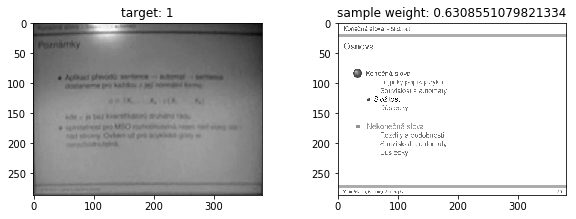

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 60))
[screen_images, page_images], targets, sample_weights = image_pairs[0]
plotted_sample_weights = set()
for index in range(len(targets)):
  screen_image = screen_images[index][:, :, 0]
  page_image = page_images[index][:, :, 0]
  target = targets[index]
  sample_weight = sample_weights[index]
  if sample_weight not in plotted_sample_weights:
    plt.subplot(len(targets) * 2, 2, len(plotted_sample_weights) * 2 + 1).imshow(screen_image, cmap='gray')
    plt.gca().set_title('target: {}'.format(target))
    plt.subplot(len(targets) * 2, 2, len(plotted_sample_weights) * 2 + 2).imshow(page_image, cmap='gray')
    plt.gca().set_title('sample weight: {}'.format(sample_weight))
    plotted_sample_weights.add(sample_weight)

In [9]:
del image_pairs

Split the dataset into training and validation parts.

In [10]:
from pickle import dump, load
from random import sample

from video699.video.annotated import get_videos


videos = get_videos().values()
validation_videos = sample(tuple(videos), len(videos) // 5)
train_videos = list(set(videos) - set(validation_videos))
train_generator = AnnotatedImagePairs(train_videos)
validation_generator = AnnotatedImagePairs(validation_videos)


INFO:__main__:Produced a dataset containing 31644 annotated image pairs
INFO:__main__:Produced a dataset containing 5336 annotated image pairs


### Standardization
Standardize the images.

In [11]:
import npstreams
import numpy as np
from tqdm import tqdm


mean_screen_image = npstreams.mean(
    rgb_screen_image
    for [rgb_screen_images, rgb_page_images], targets, sample_weights
    in tqdm(train_generator, desc='MEAN_SCREEN_IMAGE')
    for rgb_screen_image in rgb_screen_images
)
mean_page_image = npstreams.mean(
    rgb_page_image
    for [rgb_screen_images, rgb_page_images], targets, sample_weights
    in tqdm(train_generator, desc='MEAN_PAGE_IMAGE')
    for rgb_page_image in rgb_page_images
)

inverse_screen_image_stddev = 1.0 / npstreams.std(
    rgb_screen_image
    for [rgb_screen_images, rgb_page_images], targets, sample_weights
    in tqdm(train_generator, desc='INVERSE_SCREEN_IMAGE_STDDEV')
    for rgb_screen_image in rgb_screen_images
)
inverse_page_image_stddev = 1.0 / npstreams.std(
    rgb_page_image
    for [rgb_screen_images, rgb_page_images], targets, sample_weights
    in tqdm(train_generator, desc='INVERSE_PAGE_IMAGE_STDDEV')
    for rgb_page_image in rgb_page_images
)

MEAN_SCREEN_IMAGE = mean_screen_image[:, :, 0]
MEAN_PAGE_IMAGE = mean_page_image[:, :, 0]
INVERSE_SCREEN_IMAGE_STDDEV = inverse_screen_image_stddev[:, :, 0]
INVERSE_PAGE_IMAGE_STDDEV = inverse_page_image_stddev[:, :, 0]

del mean_screen_image
del mean_page_image
del inverse_screen_image_stddev
del inverse_page_image_stddev


Text(0.5, 1.0, 'page image standard deviance')

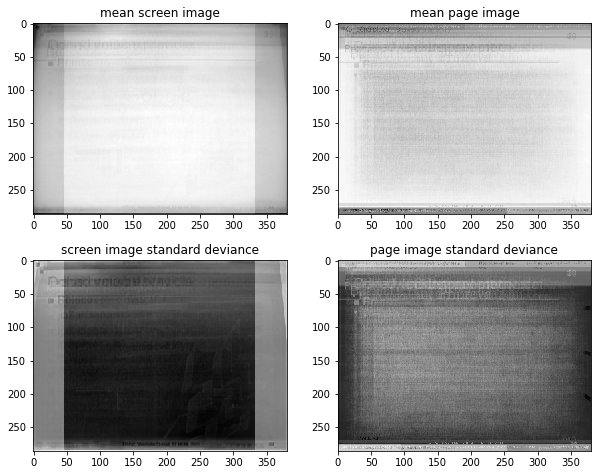

In [12]:
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1).imshow(MEAN_SCREEN_IMAGE, cmap='gray')
plt.gca().set_title('mean screen image')
plt.subplot(2, 2, 2).imshow(MEAN_PAGE_IMAGE, cmap='gray')
plt.gca().set_title('mean page image')
plt.subplot(2, 2, 3).imshow(1 / INVERSE_SCREEN_IMAGE_STDDEV, cmap='gray')
plt.gca().set_title('screen image standard deviance')
plt.subplot(2, 2, 4).imshow(1 / INVERSE_PAGE_IMAGE_STDDEV, cmap='gray')
plt.gca().set_title('page image standard deviance')plt.savefig('figures/siamese-04.pdf')

### Analysis
Inspect the produced dataset.

In [13]:
all_generator = AnnotatedImagePairs(videos)

INFO:__main__:Produced a dataset containing 36980 annotated image pairs


Since some screens have no matching pages and every screen starts with the weight of one, not zero, the weights of positive and negative samples differ slightly in their sums, i.e. there remains some class imbalance despite the sample weighting.

In [14]:
negative_weights = [weight * all_generator.weight_norm for screen, page, label, weight in all_generator.samples if label == 1]
sum(negative_weights)

20428.963657197513

In [15]:
positive_weights = [weight * all_generator.weight_norm for screen, page, label, weight in all_generator.samples if label == 0]
sum(positive_weights)

16551.036342809482

In [16]:
del all_generator

## Model

### Discovering a good local optimum


In [17]:
import keras.backend as K
from keras.models import Model, Sequential
from keras.layers import Activation, concatenate, Conv2D, Dense, Dropout, Flatten, Input, Lambda, MaxPooling2D


BASELINE_CONVNET_KERNEL_WIDTH = 3
BASELINE_CONVNET_KERNEL_HEIGHT = 3
BASELINE_MAXPOOL_WIDTH = 2
BASELINE_MAXPOOL_HEIGHT = 2
BASELINE_BOTTOM_UNITS = 32
BASELINE_TOP_UNITS = 64
BASELINE_DENSE_UNITS = 64


baseline_kernel_size = (BASELINE_CONVNET_KERNEL_WIDTH, BASELINE_CONVNET_KERNEL_HEIGHT)
baseline_pool_size = (BASELINE_MAXPOOL_WIDTH, BASELINE_MAXPOOL_HEIGHT)

baseline_convnet = Sequential([
  Conv2D(BASELINE_BOTTOM_UNITS, baseline_kernel_size, activation='relu', padding='same'),
  MaxPooling2D(pool_size=baseline_pool_size),
  Conv2D(BASELINE_BOTTOM_UNITS, baseline_kernel_size, activation='relu', padding='same'),
  MaxPooling2D(pool_size=baseline_pool_size),
  Conv2D(BASELINE_BOTTOM_UNITS, baseline_kernel_size, activation='relu', padding='same'),
  MaxPooling2D(pool_size=baseline_pool_size),
  Conv2D(BASELINE_BOTTOM_UNITS, baseline_kernel_size, activation='relu', padding='same'),
  MaxPooling2D(pool_size=baseline_pool_size),
  Conv2D(BASELINE_TOP_UNITS, baseline_kernel_size, activation='relu', padding='same'),
  Conv2D(BASELINE_TOP_UNITS, baseline_kernel_size, activation='relu', padding='same'),
  MaxPooling2D(pool_size=baseline_pool_size),
  Conv2D(BASELINE_TOP_UNITS, baseline_kernel_size, activation='relu', padding='same'),
  Conv2D(BASELINE_TOP_UNITS, baseline_kernel_size, activation='relu', padding='same'),
  MaxPooling2D(pool_size=baseline_pool_size),
  Conv2D(BASELINE_TOP_UNITS, baseline_kernel_size, activation='relu', padding='same'),
  Conv2D(BASELINE_TOP_UNITS, baseline_kernel_size, activation='relu', padding='same'),
  Flatten(),
  Dense(BASELINE_DENSE_UNITS, activation='relu'),
])

screen_baseline_input = Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 1))
screen_baseline_convnet_tensor = baseline_convnet(screen_baseline_input)

page_baseline_input = Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 1))
page_baseline_convnet_tensor = baseline_convnet(page_baseline_input)

def baseline_l2_distance(inputs):
  screen_features = inputs[:, BASELINE_DENSE_UNITS:]
  page_features = inputs[:, :BASELINE_DENSE_UNITS]
  distance = K.sqrt(K.sum((screen_features - page_features)**2, axis=-1))
  return K.expand_dims(distance)

baseline_top_dense = Sequential([
  Lambda(baseline_l2_distance),
  Dense(1, activation='sigmoid'),
])
baseline_top_dense_tensor = baseline_top_dense(concatenate([
  screen_baseline_convnet_tensor,
  page_baseline_convnet_tensor,
]))

baseline_model = Model(
  inputs=[screen_baseline_input, page_baseline_input],
  outputs=baseline_top_dense_tensor,
)

Plot and inspect the model.

In [18]:
baseline_convnet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 286, 381, 32)      320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 143, 190, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 143, 190, 32)      9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 71, 95, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 71, 95, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 35, 47, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 35, 47, 32)        9248      
__________

In [19]:
baseline_top_dense.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 1)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [20]:
baseline_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 286, 381, 1)  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 286, 381, 1)  0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 64)           313184      input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 128)          0           sequential_1[1][0]               
          

Train the model.

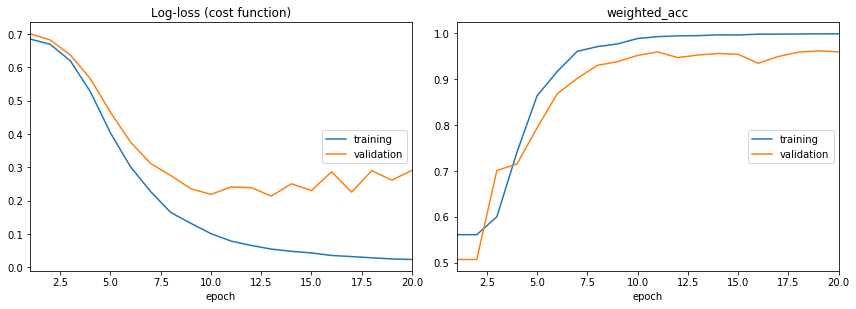

In [21]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import SGD
from livelossplot import PlotLossesKeras


BASELINE_TRAINING_REDUCE_LR_PATIENCE = 3
BASELINE_TRAINING_EARLY_STOPPING_PATIENCE = 8
BASELINE_TRAINING_EPOCHS = 20
BASELINE_LEARNING_RATE = 1e-01 / 65.6884118762211


baseline_model.compile(
  optimizer=SGD(lr=BASELINE_LEARNING_RATE),
  loss='binary_crossentropy',
  weighted_metrics=['accuracy'],
)

baseline_model_history = baseline_model.fit_generator(
  train_generator,
  validation_data=validation_generator,
  epochs=BASELINE_TRAINING_EPOCHS,
  callbacks=[
    PlotLossesKeras(),
#   EarlyStopping(patience=BASELINE_TRAINING_EARLY_STOPPING_PATIENCE),
#   ReduceLROnPlateau(patience=BASELINE_TRAINING_REDUCE_LR_PATIENCE),
  ],
  verbose=0,
)

Plot the learning curves.

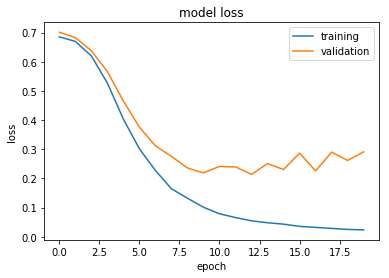

In [22]:
plt.plot(baseline_model_history.history['loss'])
plt.plot(baseline_model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'])
plt.savefig('figures/siamese-05.pdf')

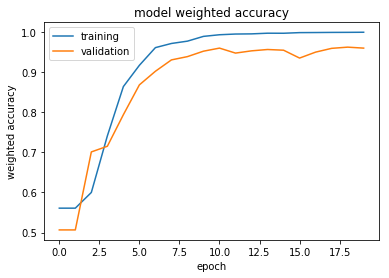

In [23]:
plt.plot(baseline_model_history.history['weighted_acc'])
plt.plot(baseline_model_history.history['val_weighted_acc'])
plt.title('model weighted accuracy')
plt.ylabel('weighted accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'])
plt.savefig('figures/siamese-05.pdf')

Plot the confusion matrix.

In [25]:
from sklearn.metrics import confusion_matrix


y_true = list(train_generator.labels)
sigmoid = baseline_model.predict_generator(train_generator)
y_pred = list(np.round(sigmoid).flatten().astype(int))
confusion_matrix(y_true, y_pred)

array([[  428,     0],
       [   61, 31155]], dtype=int64)

In [26]:
y_true = list(validation_generator.labels)
sigmoid = baseline_model.predict_generator(validation_generator)
y_pred = list(np.round(sigmoid).flatten().astype(int))
confusion_matrix(y_true, y_pred)

array([[  85,    6],
       [  51, 5194]], dtype=int64)

Visualize immediate activations for a screen image.

In [27]:
[screen_images, page_images], targets, sample_weights = next(iter(
  (inputs, targets, sample_weights)
  for inputs, targets, sample_weights in validation_generator
  if 0 in targets
))
matching_pair_index = targets.index(0)
screen_image = screen_images[matching_pair_index]
page_image = page_images[matching_pair_index]

In [28]:
layers = [
  baseline_convnet.layers[0],
  baseline_convnet.layers[2],
  baseline_convnet.layers[4],
  baseline_convnet.layers[6],
  baseline_convnet.layers[8],
  baseline_convnet.layers[9],
  baseline_convnet.layers[11],
  baseline_convnet.layers[12],
  baseline_convnet.layers[14],
  baseline_convnet.layers[15],
  baseline_convnet.layers[17],
]
layer_outputs = [layer.output for layer in layers]
layers

In [ ]:
from keras.models import Model

activation_model = Model(inputs=baseline_convnet.inputs[0], outputs=layer_outputs)

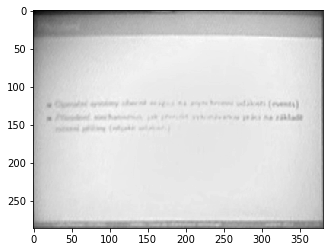

In [ ]:
plt.imshow(screen_image[:, :, 0] / INVERSE_SCREEN_IMAGE_STDDEV + MEAN_SCREEN_IMAGE, cmap='gray')
plt.savefig('figures/siamese-07.pdf')

In [ ]:
activations = activation_model.predict(np.array([screen_image]))

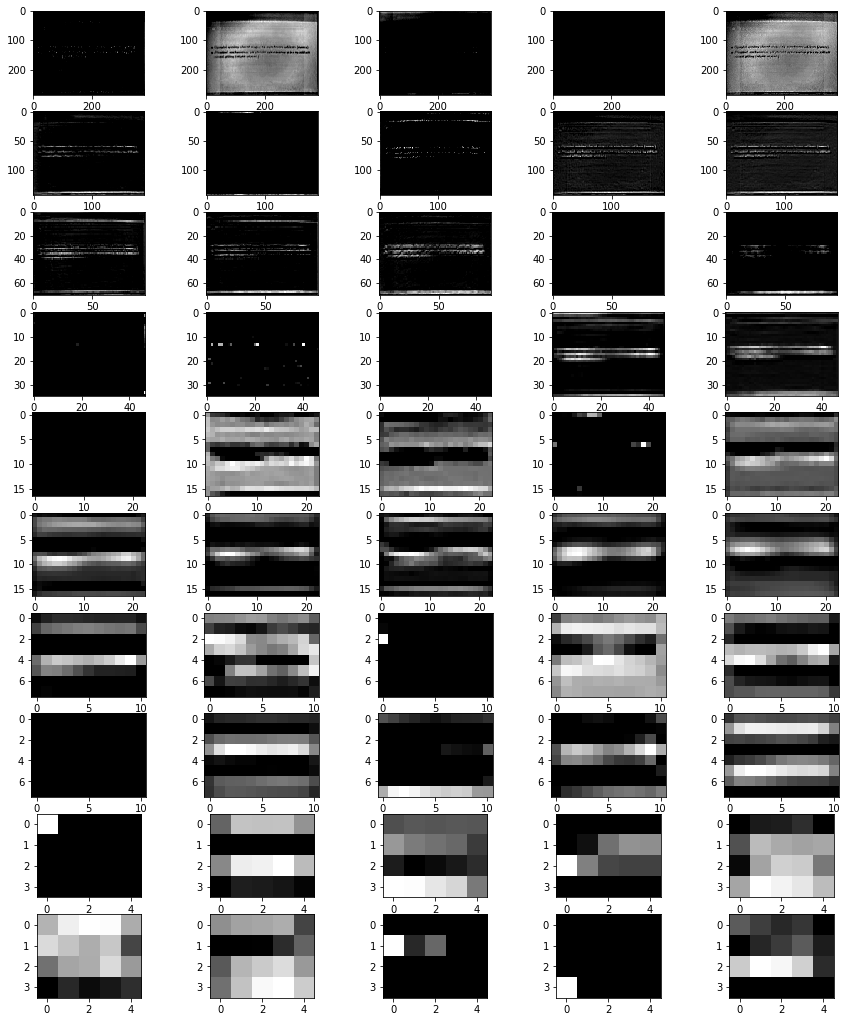

In [ ]:
plt.figure(figsize=(15, 20))

for activation_index, activation in enumerate(activations[:-1]):
    for filter_index in range(5):
        plt.subplot(
            len(activations),
            5,
            activation_index * 5 + filter_index + 1,
        ).imshow(
            activation[0, :, :, filter_index],
            cmap='gray',
        )
plt.savefig('figures/siamese-08.pdf')

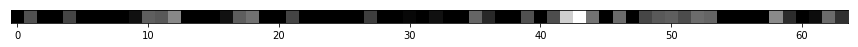

In [ ]:
plt.figure(figsize=(15, 10))
plt.yticks([])
plt.imshow(activations[-1], cmap='gray')
plt.savefig('figures/siamese-09.pdf')

Visualize immediate activations for a page image.

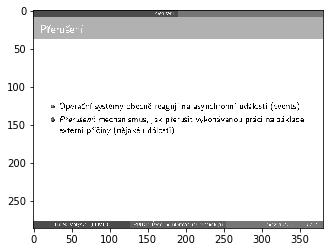

In [ ]:
plt.imshow(page_image[:, :, 0] / INVERSE_PAGE_IMAGE_STDDEV + MEAN_PAGE_IMAGE, cmap='gray')
plt.savefig('figures/siamese-10.pdf')

In [ ]:
activations = activation_model.predict(np.array([page_image]))

In [ ]:
plt.figure(figsize=(15, 20))
for activation_index, activation in enumerate(activations[:-1]):
    for filter_index in range(5):
        plt.subplot(
            len(activations),
            5,
            activation_index * 5 + filter_index + 1,
        ).imshow(
            activation[0, :, :, filter_index],
            cmap='gray',
        )
plt.savefig('figures/siamese-11.pdf')

In [ ]:
plt.figure(figsize=(15, 10))
plt.yticks([])
plt.imshow(activations[-1], cmap='gray')
plt.savefig('figures/siamese-12.pdf')

### Discovering a degenerate local optimum


In [17]:
import keras.backend as K
from keras.models import Model, Sequential
from keras.layers import Activation, concatenate, Conv2D, Dense, Dropout, Flatten, Input, Lambda, MaxPooling2D


BASELINE_CONVNET_KERNEL_WIDTH = 3
BASELINE_CONVNET_KERNEL_HEIGHT = 3
BASELINE_MAXPOOL_WIDTH = 2
BASELINE_MAXPOOL_HEIGHT = 2
BASELINE_BOTTOM_UNITS = 32
BASELINE_TOP_UNITS = 64
BASELINE_DENSE_UNITS = 64


baseline_kernel_size = (BASELINE_CONVNET_KERNEL_WIDTH, BASELINE_CONVNET_KERNEL_HEIGHT)
baseline_pool_size = (BASELINE_MAXPOOL_WIDTH, BASELINE_MAXPOOL_HEIGHT)

baseline_convnet = Sequential([
  Conv2D(BASELINE_BOTTOM_UNITS, baseline_kernel_size, activation='relu', padding='same'),
  MaxPooling2D(pool_size=baseline_pool_size),
  Conv2D(BASELINE_BOTTOM_UNITS, baseline_kernel_size, activation='relu', padding='same'),
  MaxPooling2D(pool_size=baseline_pool_size),
  Conv2D(BASELINE_BOTTOM_UNITS, baseline_kernel_size, activation='relu', padding='same'),
  MaxPooling2D(pool_size=baseline_pool_size),
  Conv2D(BASELINE_BOTTOM_UNITS, baseline_kernel_size, activation='relu', padding='same'),
  MaxPooling2D(pool_size=baseline_pool_size),
  Conv2D(BASELINE_TOP_UNITS, baseline_kernel_size, activation='relu', padding='same'),
  Conv2D(BASELINE_TOP_UNITS, baseline_kernel_size, activation='relu', padding='same'),
  MaxPooling2D(pool_size=baseline_pool_size),
  Conv2D(BASELINE_TOP_UNITS, baseline_kernel_size, activation='relu', padding='same'),
  Conv2D(BASELINE_TOP_UNITS, baseline_kernel_size, activation='relu', padding='same'),
  MaxPooling2D(pool_size=baseline_pool_size),
  Conv2D(BASELINE_TOP_UNITS, baseline_kernel_size, activation='relu', padding='same'),
  Conv2D(BASELINE_TOP_UNITS, baseline_kernel_size, activation='relu', padding='same'),
  Flatten(),
  Dense(BASELINE_DENSE_UNITS, activation='relu'),
])

screen_baseline_input = Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 1))
screen_baseline_convnet_tensor = baseline_convnet(screen_baseline_input)

page_baseline_input = Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 1))
page_baseline_convnet_tensor = baseline_convnet(page_baseline_input)

def baseline_l2_distance(inputs):
  screen_features = inputs[:, BASELINE_DENSE_UNITS:]
  page_features = inputs[:, :BASELINE_DENSE_UNITS]
  distance = K.sqrt(K.sum((screen_features - page_features)**2, axis=-1))
  return K.expand_dims(distance)

baseline_top_dense = Sequential([
  Lambda(baseline_l2_distance),
  Dense(1, activation='sigmoid'),
])
baseline_top_dense_tensor = baseline_top_dense(concatenate([
  screen_baseline_convnet_tensor,
  page_baseline_convnet_tensor,
]))

baseline_model = Model(
  inputs=[screen_baseline_input, page_baseline_input],
  outputs=baseline_top_dense_tensor,
)

Plot and inspect the model.

In [18]:
baseline_convnet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 286, 381, 32)      320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 143, 190, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 143, 190, 32)      9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 71, 95, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 71, 95, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 35, 47, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 35, 47, 32)        9248      
__________

In [19]:
baseline_top_dense.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 1)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [20]:
baseline_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 286, 381, 1)  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 286, 381, 1)  0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 64)           313184      input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 128)          0           sequential_1[1][0]               
          

Train the model.

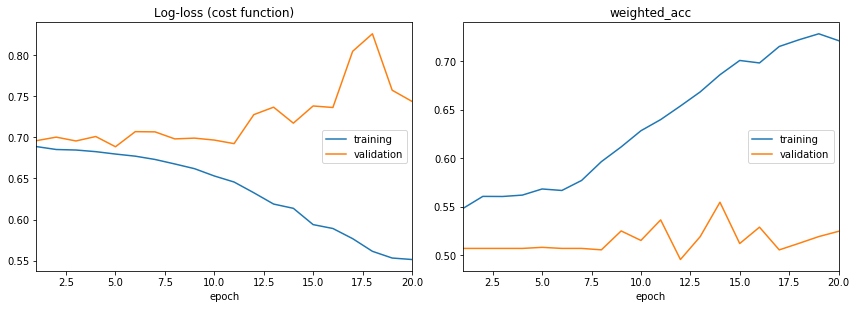

In [21]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import SGD
from livelossplot import PlotLossesKeras


BASELINE_TRAINING_REDUCE_LR_PATIENCE = 3
BASELINE_TRAINING_EARLY_STOPPING_PATIENCE = 8
BASELINE_TRAINING_EPOCHS = 20
BASELINE_LEARNING_RATE = 1e-01 / 65.6884118762211


baseline_model.compile(
  optimizer=SGD(lr=BASELINE_LEARNING_RATE),
  loss='binary_crossentropy',
  weighted_metrics=['accuracy'],
)

baseline_model_history = baseline_model.fit_generator(
  train_generator,
  validation_data=validation_generator,
  epochs=BASELINE_TRAINING_EPOCHS,
  callbacks=[
    PlotLossesKeras(),
#   EarlyStopping(patience=BASELINE_TRAINING_EARLY_STOPPING_PATIENCE),
#   ReduceLROnPlateau(patience=BASELINE_TRAINING_REDUCE_LR_PATIENCE),
  ],
  verbose=0,
)

Plot the learning curves.

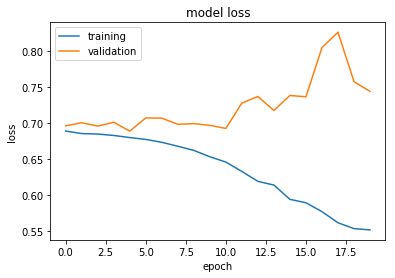

In [22]:
plt.plot(baseline_model_history.history['loss'])
plt.plot(baseline_model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'])
plt.savefig('figures/siamese-13.pdf')

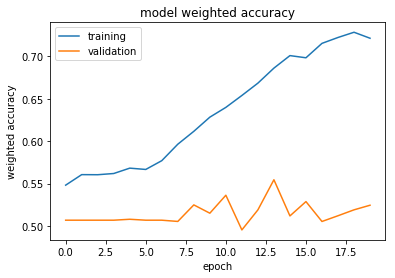

In [23]:
plt.plot(baseline_model_history.history['weighted_acc'])
plt.plot(baseline_model_history.history['val_weighted_acc'])
plt.title('model weighted accuracy')
plt.ylabel('weighted accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'])
plt.savefig('figures/siamese-14.pdf')

Plot the confusion matrix.

In [24]:
from sklearn.metrics import confusion_matrix


y_true = list(train_generator.labels)
sigmoid = baseline_model.predict_generator(train_generator)
y_pred = list(np.round(sigmoid).flatten().astype(int))
confusion_matrix(y_true, y_pred)

array([[  350,    78],
       [ 9380, 21836]], dtype=int64)

In [25]:
y_true = list(validation_generator.labels)
sigmoid = baseline_model.predict_generator(validation_generator)
y_pred = list(np.round(sigmoid).flatten().astype(int))
confusion_matrix(y_true, y_pred)

array([[  36,   55],
       [1689, 3556]], dtype=int64)

Visualize immediate activations for a screen image.

In [54]:
[screen_images, page_images], targets, sample_weights = next(iter(
  (inputs, targets, sample_weights)
  for inputs, targets, sample_weights in validation_generator
  if 0 in targets
))
matching_pair_index = targets.index(0)
screen_image = screen_images[matching_pair_index]
page_image = page_images[matching_pair_index]

In [55]:
layers = [
  baseline_convnet.layers[0],
  baseline_convnet.layers[2],
  baseline_convnet.layers[4],
  baseline_convnet.layers[6],
  baseline_convnet.layers[8],
  baseline_convnet.layers[9],
  baseline_convnet.layers[11],
  baseline_convnet.layers[12],
  baseline_convnet.layers[14],
  baseline_convnet.layers[15],
  baseline_convnet.layers[17],
]
layer_outputs = [layer.output for layer in layers]
layers

In [36]:
from keras.models import Model

activation_model = Model(inputs=baseline_convnet.inputs[0], outputs=layer_outputs)

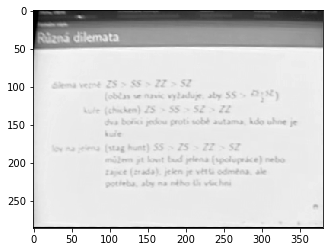

In [56]:
plt.imshow(screen_image[:, :, 0] / INVERSE_SCREEN_IMAGE_STDDEV + MEAN_SCREEN_IMAGE, cmap='gray')
plt.savefig('figures/siamese-15.pdf')

In [60]:
activations = activation_model.predict(np.array([screen_image]))

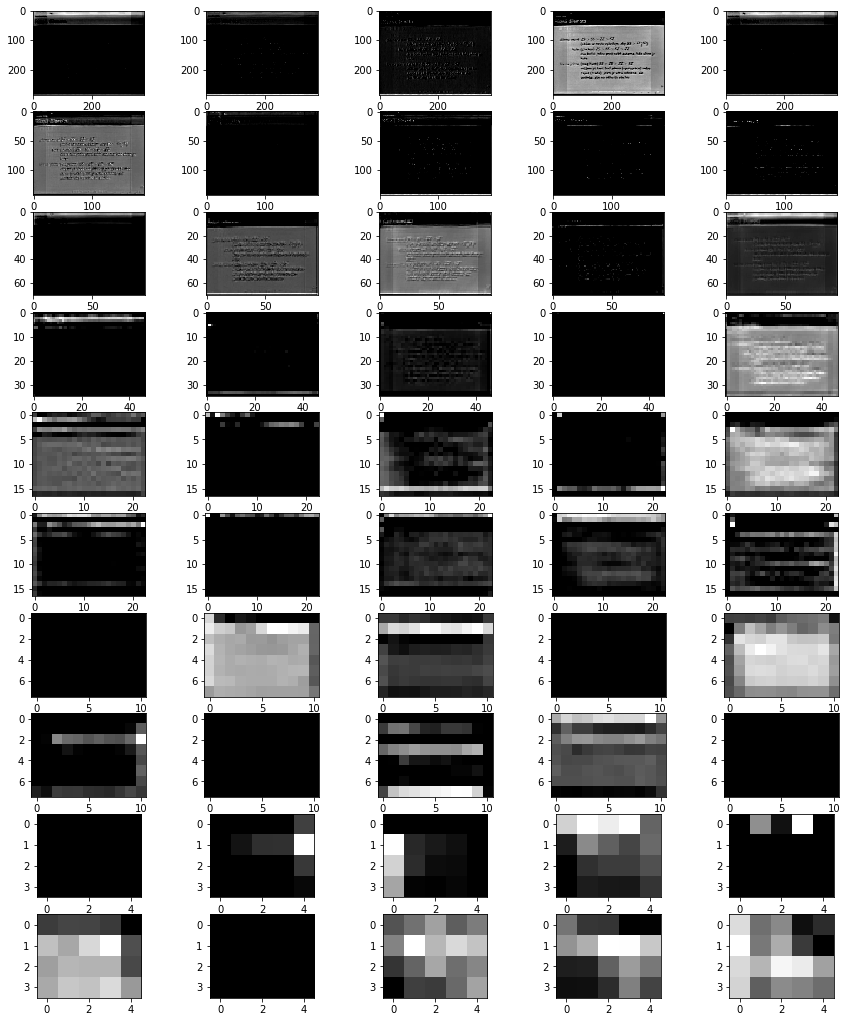

In [61]:
plt.figure(figsize=(15, 20))

for activation_index, activation in enumerate(activations[:-1]):
    for filter_index in range(5):
        plt.subplot(
            len(activations),
            5,
            activation_index * 5 + filter_index + 1,
        ).imshow(
            activation[0, :, :, filter_index],
            cmap='gray',
        )
plt.savefig('figures/siamese-16.pdf')

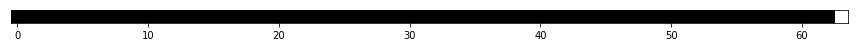

In [62]:
plt.figure(figsize=(15, 10))
plt.yticks([])
plt.imshow(activations[-1], cmap='gray')
plt.savefig('figures/siamese-17.pdf')

Visualize immediate activations for a page image.

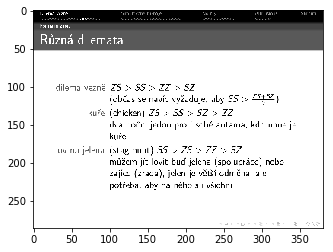

In [63]:
plt.imshow(page_image[:, :, 0] / INVERSE_PAGE_IMAGE_STDDEV + MEAN_PAGE_IMAGE, cmap='gray')
plt.savefig('figures/siamese-18.pdf')

In [64]:
activations = activation_model.predict(np.array([page_image]))

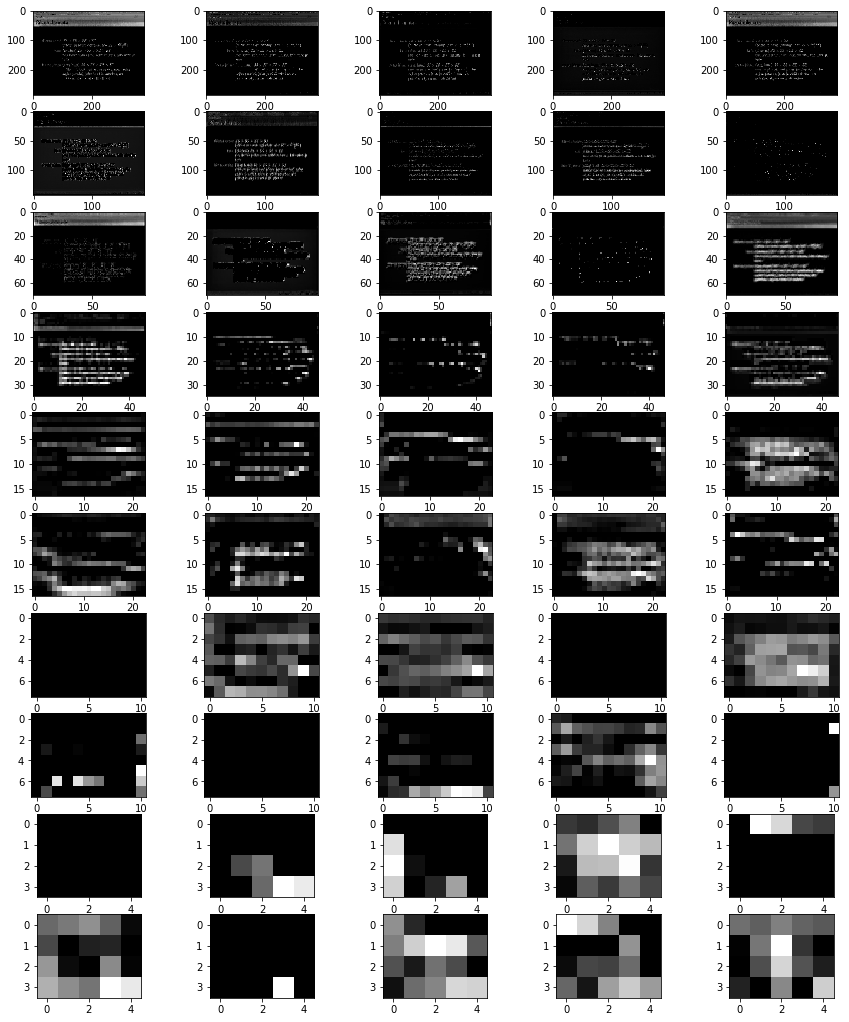

In [65]:
plt.figure(figsize=(15, 20))
for activation_index, activation in enumerate(activations[:-1]):
    for filter_index in range(5):
        plt.subplot(
            len(activations),
            5,
            activation_index * 5 + filter_index + 1,
        ).imshow(
            activation[0, :, :, filter_index],
            cmap='gray',
        )
plt.savefig('figures/siamese-19.pdf')

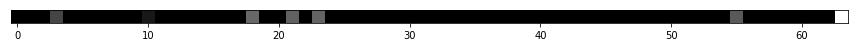

In [66]:
plt.figure(figsize=(15, 10))
plt.yticks([])
plt.imshow(activations[-1], cmap='gray')
plt.savefig('figures/siamese-20.pdf')